<H1>Classification using Normalized Histograms</H1>

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [11]:
datasets = ['Linearly seperable', 'Nonlinearly separable', 'Real world']
classifiers = ['Same diagonal covariance matrix for all class', 'Same full covariance matrix for all class', 'Different diagonal covariance matrix for each class', 'Different full covariance matrix for each class']

for i in range(len(datasets)):
    print(str(i+1)+')'+datasets[i])
dataset_option = int(input('Enter Dataset Number: '))
print('Dataset choosen = %d'%(int(dataset_option)))

if dataset_option == 1:
    path = r'D:/Pattern Recognition/Assignment/Assignment_01/ls_data'
    nclass = 2
elif dataset_option == 2:
    path = r'D:/Pattern Recognition/Assignment/Assignment_01/nls_data'
    nclass = 2
else:
    path = r'D:/Pattern Recognition/Assignment/Assignment_01/real_world_data'
    nclass = 3
os.chdir(path)
files = []
for file in os.listdir(path):
    if file.endswith(".txt"):
        files.append(os.path.join(path, file))
print(path)
print(files)

1)Linearly seperable
2)Nonlinearly separable
3)Real world


Enter Dataset Number:  2


Dataset choosen = 2
D:/Sujeet_PhD/Course_Work/Pattern Recognition/Assignment/Assignment_01/nls_data
['D:/Sujeet_PhD/Course_Work/Pattern Recognition/Assignment/Assignment_01/nls_data\\class1.txt', 'D:/Sujeet_PhD/Course_Work/Pattern Recognition/Assignment/Assignment_01/nls_data\\class2.txt']


In [12]:
## Split the training and tesing data ##
def get_data(dataset):
    train = dataset.sample(frac=0.80, random_state=100)
    test = dataset[~dataset.index.isin(train.index)]
    return train, test

train_data = pd.DataFrame(columns=['X', 'Y', 'label'])
test_data = pd.DataFrame(columns=['X', 'Y', 'label'])
alldata = pd.DataFrame(columns=['X', 'Y', 'label'])
class_mean, class_cov_mat = np.empty([nclass, 2]), np.empty([nclass, 2, 2])

for file, i in zip(files, range(len(files))):
    if dataset_option == 3:
        data = pd.read_csv(file, header=None, delim_whitespace=True)
    else:
        data = pd.read_csv(file, header=None)
    data.rename(columns = {0:'X', 1:'Y'}, inplace = True)
    data['label'] = [i for _ in range(data.shape[0])]
    data=data.sample(frac=1).reset_index(drop=True)
    ### Split data in training and test dataset
    temp_train, temp_test = get_data(data)
    train_data = train_data.append(temp_train)
    test_data = test_data.append(temp_test)
    alldata = alldata.append(data)

In [13]:
### Set Bins Size
bins_size = 50
### To find the boundary for bins
(xmin, xmax), (ymin, ymax) = alldata[['X', 'Y']].apply(lambda x: pd.Series([x.min(), x.max()])).T.values.tolist()

binsX, binsY, probX, probY = [], [], [], []
for i in range(len(files)):
    ### Normalized histogram for feature-1
    hist, bins = np.histogram(train_data[train_data['label']==i]['X'], bins=bins_size, range=(xmin-0.01, xmax+0.01), density=True)
    ### Stores bins of each classes
    binsX.append(bins)
    ### Stores pdf of each classes
    probX.append(hist * np.diff(bins))
    ### Normalized histogram for feature-2
    hist, bins = np.histogram(train_data[train_data['label']==i]['Y'], bins=bins_size, range=(ymin-0.01, ymax+0.01), density=True)
    ### Stores bins of each classes
    binsY.append(bins)
    ### Stores pdf of each classes
    probY.append(hist * np.diff(bins))

### Classify the test data
def classifier(test_data):
    prob_classX, prob_classY = [], []
    if isinstance(test_data, list):
        for i in range(len(files)):
            ### Map the data points to a bins range
            map_to_bins = np.digitize(test_data[0], binsX[i])
            ### Probability of feature-1 for each data points
            prob_classX.append(probX[i][map_to_bins-1])
            ### Map the data points to a bins range
            map_to_bins = np.digitize(test_data[1], binsY[i])
            ### Probability of feature-2 for each data points
            prob_classY.append(probY[i][map_to_bins-1])
    else:
        for i in range(len(files)):
            ### Map the data points to a bins range
            map_to_bins = np.digitize(test_data['X'], binsX[i])
            ### Probability of feature-1 for each data points
            prob_classX.append([probX[i][j-1] for j in map_to_bins])
            ### Map the data points to a bins range
            map_to_bins = np.digitize(test_data['Y'], binsY[i])
            ### Probability of feature-2 for each data points
            prob_classY.append([probY[i][j-1] for j in map_to_bins])
    ### For test data probability to each class
    prob_Class = np.multiply(prob_classX, prob_classY)
    ### Get the class label with highest probability
    predicted_label = np.argmax(prob_Class, axis=0)
    return predicted_label


In [14]:
## Calculate other parameters related to confusion matrix ##
# Here we are getting 3 confusion matrix - for LS, NLS and for Real Data. 
def confsnMatParameter(cmat):
    # Classification accuracy
    classification_accuracy = np.sum(cmat.diagonal()) * 100.0 / np.sum(cmat)
#     # precision for every class
#     rsum = np.sum(cmat, axis=1)
#     csum = np.sum(cmat, axis=0)
#     precision = []
#     recall = []
#     fmeasure = []
#     for i in range(len(cmat)):
#         # precision for every class
#         precision.append(cmat[i][i] * 1.0 / rsum[i])

#         # recall for every class
#         recall.append(cmat[i][i] * 1.0 / csum[i])
#         # F-measure for every class
#         fmeasure.append(2.0 * precision[i] * recall[i] / (precision[i] + recall[i]))
#     # mean precision
#     mprecision = sum(precision) * 1.0 / len(cmat)
#     # mean recall
#     mrecall = sum(recall) * 1.0 / len(cmat)
#     # mean F-measure
#     mfmeasure = sum(fmeasure) * 1.0 / len(cmat)
#     return classification_accuracy, precision, recall, fmeasure, mprecision, mrecall, mfmeasure
    return classification_accuracy

# Calculating confusion matrix ##
CM = np.zeros([nclass, nclass])
predicted_label = list(classifier(test_data))
actual_label = list(test_data['label'])
for i in range(len(actual_label)):
    if predicted_label[i] == 0:
        if actual_label[i] == 0:
            CM[0][0] += 1
        if actual_label[i] == 1:
            CM[0][1] += 1
        if actual_label[i] == 2:
            CM[0][2] += 1
    elif predicted_label[i] == 1:
        if actual_label[i] == 0:
            CM[1][0] += 1
        if actual_label[i] == 1:
            CM[1][1] += 1
        if actual_label[i] == 2:
            CM[1][2] += 1
    else:
        if actual_label[i] == 0:
            CM[2][0] += 1
        if actual_label[i] == 1:
            CM[2][1] += 1
        if actual_label[i] == 2:
            CM[2][2] += 1

# classification_accuracy, precision, recall, fmeasure, mprecision, mrecall, mfmeasure = confsnMatParameter(CM)
classification_accuracy = confsnMatParameter(CM)

print ("\nThe Confusion Matrix:")
print (CM)
print ("\nClassification Accuracy = " + str(classification_accuracy))
# for i in range(len(CM)):
#     print ("\nPrecision for Class" + str(i + 1) + " = " + str(precision[i]))
# print ("\nMean Precision = " + str(mprecision))
# for i in range(len(CM)):
#     print ("\nRecall for Class" + str(i + 1) + " = " + str(recall[i]))
# print ("\nMean Recall = " + str(mrecall))
# for i in range(len(CM)):
#     print ("\nF-Measure for Class" + str(i + 1) + " = " + str(fmeasure[i]))
# print ("\nMean F-measure = " + str(mfmeasure))


The Confusion Matrix:
[[170.  13.]
 [ 30. 187.]]

Classification Accuracy = 89.25


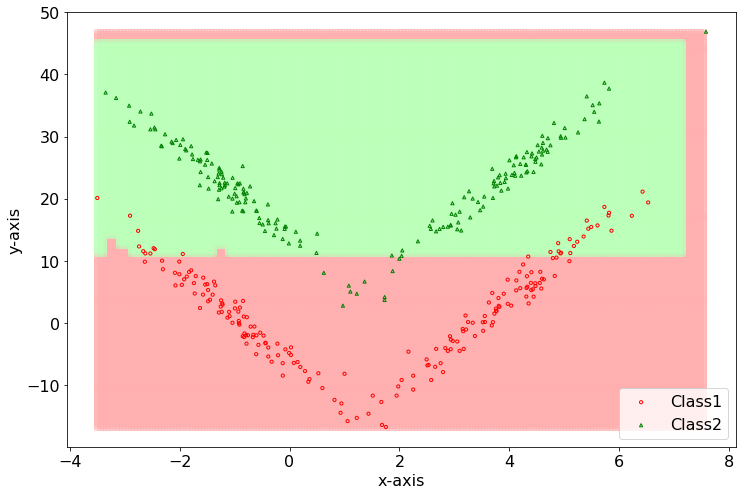

<Figure size 432x288 with 0 Axes>

In [15]:
## For ploting decision boundary region 
def boundaryPlot(alldataset, nclass, name):
    ### Find the datapoints boundary
    (xmin, xmax), (ymin, ymax) = alldataset[['X', 'Y']].apply(lambda x: pd.Series([x.min(), x.max()])).T.values.tolist()
    x0, x1, x2, y0, y1, y2 = [], [], [], [], [], []
    for x in np.arange(xmin, xmax, (xmax-xmin)/200.0):
        for y in np.arange(ymin, ymax, (ymax-ymin)/200.0):
            c = classifier([x, y])
            if c == 0:
                x0.append(x)
                y0.append(y)
            elif c == 1:
                x1.append(x)
                y1.append(y)
            else:
              x2.append(x)
              y2.append(y)

    colors = ("red", "green", "blue")
    cat_color = (u'#FFAFAF', u'#BBFFB9', u'#BBB9FF')
    groups = ("Class1", "Class2", "Class3")
    mk = ('o', '^', 's')
    ### Create plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.scatter(x0, y0, alpha=0.4, marker='s', edgecolors=cat_color[0], facecolor=cat_color[0], s=40)
    ax.scatter(x1, y1, alpha=0.4, marker='s', edgecolors=cat_color[1], facecolor=cat_color[1], s=40)
    ax.scatter(x2, y2, alpha=0.4, marker='s', edgecolors=cat_color[2], facecolor=cat_color[2], s=40)
    for i in alldataset['label'].unique():
        ax.scatter(alldataset[alldataset['label']==i]['X'], alldataset[alldataset['label']==i]['Y'], alpha=1.0, marker=mk[i], edgecolors=colors[i], facecolor='none', s=10, label=groups[i])
    # plt.title('Decision region of dataset in Class1, Class2, and Class3')
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.legend(loc=4)
    plt.rcParams.update({'font.size': 16})
    fig.savefig("..\\Boundary_Plot_Histogram_"+ name +".png", dpi=300, format='png', bbox_inches='tight')
    plt.show()
    plt.clf()

# dataplot for all training dataset
if dataset_option == 1:
    name = 'LS'
elif dataset_option == 2:
    name = 'NLS'
else:
    name = 'RealData'
    
boundaryPlot(test_data, nclass, name)

In [254]:
# plt.hist(train_data[train_data['label']==2]['Y'], bins)